# Classification d'images par Transfer Learning

Classification d'images de déchets avec un jeu de données réduit.


## Méthodes utilisées
On va donc utiliser le Transfer Learning et le Fine Tuning pour classifier ces images. 

Le `Transfer Learning` consiste à "transférer" les "connaissances" acquises sur un modéle pré-entrainé à notre modèle. En général, on enlève la dernière couche dense, que l'on remplace par notre couche de dense du nombre de classes de notre jeu de données.

Le modèle pré-entrainé est entrainé sur l'ensemble de données ImageNet qui est un énorme ensemble de données composé de plus de 14 millions d'images de plus de 22 000 catégories différentes.

L'apprentissage par transfert a du sens ici car l'ensemble de données `ImageNet` contient un nombre d'images beaucoup plus important (14 millions) que l'ensemble de nos données. Cela augmente la vitesse d'apprentissage de notre modèle et la précision de nos prédictions.

Le `Fine Tuning` consiste à ré-entrainer certaines couches du modèle pré-entrainé sur nos données afin d'obtenir de meilleurs résultats. Mais attention au sur-apprentissage...

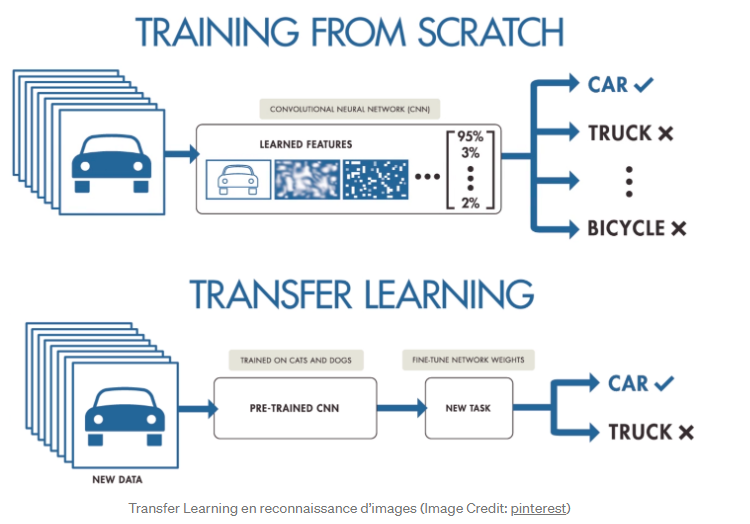

`Tensor Flow (Keras)` est utilisé pour implémenter ce modèle.

## Jeu de données
Le dataset d'images de déchets contient des images pour 6 différentes classes :
- plastic
- cardboard
- glass
- paper
- trash
- metal

Le dataset a été réduit afin de ne pas dépasser la taille exigée du projet (20Mo). Il est déjà divisé en dossiers `train`, `validation` et `test` en respectant respectivement les proportions 80%, 10%, 10%. On a 1178 images ( environ 200 images par classes).


## Code

Pour commencer, il faut installer les packages nécessaires, en particulier :
- tensorflow
- matplotlib
- numpy

Lancer la ligne ci-dessous, pour installer automatiquement les packages nécessaires.

In [1]:
#!pip install -r requirements.txt

In [22]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.layers import Lambda
from keras.callbacks import EarlyStopping


Constantes:

In [3]:
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 320
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 64
NB_CLASSES = 6

### Chargement du jeu de données :

On charge les jeux de données grâce à la fonction `image_dataset_from_directory` avec le paramètre `label_mode='categorical'` qui nous permet de charger les labels en encodage one-hot. En lui donnant la taille d'image IMAGE_SIZE, les images sont automatiquement resizées à cette taille. On utilise aussi le paramètre `batch_size` pour créer des lots d'échantillons de taille BATCH_SIZE (sauf le dernier, qui peut être plus petit).

In [32]:
path_data = os.getcwd() + '\\dataset_images'
train_dir = path_data + "\\train"
validation_dir = path_data + "\\validation"
test_dir = path_data + "\\test"


print("Loading training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            image_size=IMAGE_SIZE,
                                                            batch_size=BATCH_SIZE,
                                                            label_mode='categorical')
print("Loading validation dataset...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 image_size=IMAGE_SIZE,
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode='categorical')
print("Loading test dataset...")
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           image_size=IMAGE_SIZE,
                                                           batch_size=BATCH_SIZE,
                                                           label_mode='categorical')

Loading training dataset...
Found 937 files belonging to 6 classes.
Loading validation dataset...
Found 123 files belonging to 6 classes.
Loading test dataset...
Found 118 files belonging to 6 classes.


On met en cache, mélange et prétraite les données pour accélerer le training :
 - cache(): cache en mémoire le dataset (évite de répéter les transformations de préprocessing appliquées à l'input)
 - shuffle(BUFFER_SIZE): mélange les échantillons, BUFFER_SIZE doit etre suffisamment grand pour un brassage correct
 - prefetch(): le prétraitement des données de l'étape N+1 est effectué en même temps que le modèle entraine l'étape N
   

In [5]:

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

On utilise l'augmentation de données car notre jeu de données est de petite taille et on a beaucoup de classes.  
`RandomFlip`: "horizontal" est un retournement aléatoire gauche-droite et "vertical" est un retournement aléatoire haut-bas  
`RandomRotation(0.2)`: résulte à une sortie tournée aléatoirement dans l'intervalle [-20% * 2pi, 20% * 2pi]

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Affichons l'image originale puis les images après application de l'augmentation de données :

(-0.5, 319.5, 319.5, -0.5)

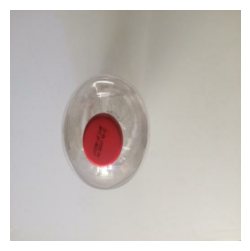

In [57]:
plt.figure(figsize=(3, 3))
original_image = ""
for image, _ in train_dataset.take(1):
    original_image = image[0]
plt.imshow(original_image/255.)
plt.axis('off')

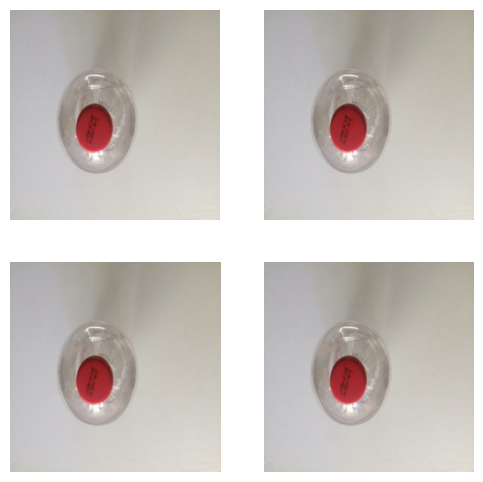

In [65]:
plt.figure(figsize=(6, 6))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0))
    plt.imshow(augmented_image[0] / 255.)
    plt.axis('off')

### Initialisation du modèle :

Sur Keras, il y a plusieurs modèles pré-entrainés disponible, on voit les résultats sur cette page : https://keras.io/api/applications/

J'ai testé avec `InceptionResNetV2` et Xception. Et j'obtiens de meilleurs résultats avec le premier, donc on va faire la suite avec ce modèle.

On initialise le modèle pré-entrainé avec le paramètre `include_top=False` pour que la première couche soit automatiquement retirée. La taille des images est de (320,320) pour que le calcul soit plus rapide (et on ne perd pas sur les résulats).

Dans le cas standard du Transfer Learning, on met la propriété trainable sur False sur le modèle `pre_trained_model.trainable = False` (ce qui impacte toutes les couches). 

In [59]:
import keras.applications.inception_resnet_v2 as inception_resnet_v2

def get_pre_trained_model():
    pre_trained_model = inception_resnet_v2.InceptionResNetV2(
                                include_top=False,
                                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
                                weights='imagenet')
    pre_trained_model.trainable = False
    return pre_trained_model

On va créer notre modèle grâce à l'API Functional de Keras.  
D'abord le préprocessing des données :
 - `data_augmentation` définie plus haut
 - `inception_resnet_v2.preprocess_input` la fonction de préprocessing du modèle pré-entrainé

Ensuite on ajoute notre modèle pré-entrainé  avec la fonction `get_pre_trained_model()`. 
On met bien sur `training=False` pour que le modèle pré-entrainé se lance en mode d'inférence (et non en mode entrainement). Cela sera surtout important pour le Fine-Tuning plus tard.

On ajoute une couche de `GlobalAveragePooling2D` pour stabiliser et approcher une invariance par translation. 
La couche de `Dropout` à 20% permet de régulariser.

La dernière couche est une couche `Dense` de NB_CLASSES sorties. Avec une fonction d'activation 'softmax' car chaque image possède une seule classe à détecter.

In [10]:
def get_model():
    inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    x = data_augmentation(inputs)
    x = inception_resnet_v2.preprocess_input(x)
    x = get_pre_trained_model()(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x) 
    outputs = keras.layers.Dense(NB_CLASSES, activation='softmax')(x)
    return keras.Model(inputs, outputs)

On applique un `EarlyStopping` pour arreter le training quand le modèle ne s'améliore plus.  
Ici avec ces paramètres, on attend 2 épochs sans amélioration (`patience=2`). Une amélioration est caractérisée par une augmentation (`mode='max'`) de plus de 0.001 (`min_delta=0.001`) de la valeur absolue de la variable observée (`monitor='val_categorical_accuracy'`), l'accuracy sur le set de validation. Quand on est dans un cas d'early stop, on récupère les poids calculés sur l'epoch qui a eu les meilleurs résultats sur la variable monitorée (`restore_best_weights=True`).

In [11]:
def get_callbacks():
    callbacks = []
    # val_categorical_accuracy pour metrics de validation
    early_stop = EarlyStopping(patience=2, 
                               verbose=1, 
                               monitor='val_categorical_accuracy', 
                               mode='max', 
                               min_delta=0.001,
                               restore_best_weights=True)
    callbacks = [early_stop]
    return callbacks

Une fonction qui permet d'afficher les graphes de résultats sur le set de training vs le set de validation. Et d'observer si on sur entraine ou pas.

In [12]:
def show_plots(results):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(results.history['loss'], 
             color='b', 
             label="Training loss")
    ax1.plot(results.history['val_loss'], 
             color='r', 
             label="validation loss")
    ax1.set_yticks(np.arange(0, 0.7, 0.1))
    ax1.legend()

    ax2.plot(results.history['categorical_accuracy'], 
             color='b', 
             label="Training accuracy")
    ax2.plot(results.history['val_categorical_accuracy'], 
             color='r', 
             label="Validation accuracy")
    ax2.legend()

    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return

Dans la fonction `train_and_test_model`:
- on `compile` le modèle avec comme fonction de perte une entropie croisée CategoricalCrossentropy car on a plus de 2 classes à identifier et les labels sont fournis avec une représentation one-hot. On utilise l'optimizer Adam.
- ensuite on `entraine` notre modèle avec comme données de training : train_dataset, comme données de validation : validation_dataset, les callbacks tels que l'early stopping
- puis on montre les graphiques des `courbes` de loss et d'accuracy du set de validation vs le set de training,
- pour terminer on `évalue` notre modèle avec le set de test, et on affiche le résultat d'accuracy.

In [13]:
def train_and_test_model(model_to_train, epochs=20, learning_rate=0.001):
    t_start = time.time()
    model_to_train.compile(loss=keras.losses.CategoricalCrossentropy(),
                           optimizer=keras.optimizers.Adam(learning_rate),
                           metrics=[keras.metrics.CategoricalAccuracy()])
    
    results = model_to_train.fit(train_dataset,
                                 epochs=epochs,
                                 validation_data=validation_dataset,
                                 callbacks= get_callbacks())

    print(f"End Model Fit, Time Elapsed: {(time.time()-t_start) /60} minutes")
        
    show_plots(results)

    _, accuracy = model_to_train.evaluate(test_dataset)

    print('accuracy on test set = ', round((accuracy * 100), 2), '% ')
    return results

In [14]:
# initialisation du modèle

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 320, 320, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 320, 320, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 320, 320, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                             

### Transfer Learning

Epoch 1/20
15/15 [==============================] - 406s 26s/step - loss: 1.5248 - categorical_accuracy: 0.4386 - val_loss: 1.1824 - val_categorical_accuracy: 0.5935
Epoch 2/20
15/15 [==============================] - 340s 23s/step - loss: 1.0043 - categorical_accuracy: 0.6969 - val_loss: 0.9001 - val_categorical_accuracy: 0.6829
Epoch 3/20
15/15 [==============================] - 343s 23s/step - loss: 0.7853 - categorical_accuracy: 0.7577 - val_loss: 0.7441 - val_categorical_accuracy: 0.7642
Epoch 4/20
15/15 [==============================] - 340s 23s/step - loss: 0.6626 - categorical_accuracy: 0.7812 - val_loss: 0.7068 - val_categorical_accuracy: 0.7480
Epoch 5/20
15/15 [==============================] - 340s 23s/step - loss: 0.5947 - categorical_accuracy: 0.8047 - val_loss: 0.6662 - val_categorical_accuracy: 0.7561
Epoch 5: early stopping
End Model Fit, Time Elapsed: 29.48042350212733 minutes


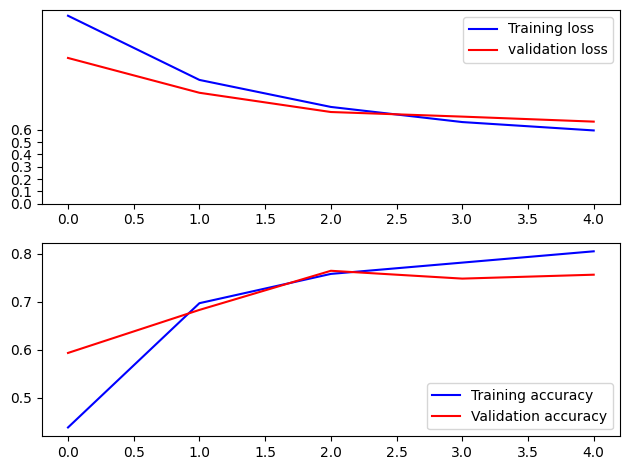

2/2 [==============================] - 36s 17s/step - loss: 0.7291 - categorical_accuracy: 0.7797
accuracy on test set =  77.97 % 


In [15]:
results_tl = train_and_test_model(model)

Les résultats pour la dernière epoch sont (car non visible sur le pdf):  
Epoch 5/20  
15/15 [==============================] - ETA: 0s - loss: 0.5947 - categorical_accuracy: 0.8047 Restoring model weights from the end of the best epoch: 3.  
15/15 [==============================] - 340s 23s/step - loss: 0.5947 - categorical_accuracy: 0.8047 - val_loss: 0.6662 - val_categorical_accuracy: 0.7561

On va voir si l'on peut améliorer nos résultats avec le Fine Tuning.

### Fine Tuning

Une fois que le modèle a convergé sur les nouvelles données, on peut essayer de le ré-entrainer en "dégelant" (trainable = True) certaines couches, ou la totalité. On met la propriété `trainable` du modèle sur True, alors toutes les couches du modèle sont changées sur trainable = True. Le paramètre `fine_tune_at` permet de fixer à partir de quelle couche on veut réentrainer le modèle.

On va utiliser un learning rate très petit, car on va entrainer un modèle beaucoup plus volumineux sur très peu de données (cela permet d'éviter le sur-apprentissage). De plus, on ne veut pas appliquer des changements trop importants aux poids déja calculés.

In [46]:
def set_frozen_layers(fine_tune_at):
    pretrained_model = model.layers[4]
    pretrained_model.trainable = True

    print("nombre de couches gelées :", fine_tune_at, "/", len(pretrained_model.layers))
    
    if fine_tune_at != "all":
        for layer in pretrained_model.layers[:fine_tune_at]:
            layer.trainable = False

**Test 1** : 280 couches à ré-entrainer

nombre de couches gelées : 500 / 780
Epoch 1/20
15/15 [==============================] - 599s 39s/step - loss: 0.6396 - categorical_accuracy: 0.7812 - val_loss: 0.6375 - val_categorical_accuracy: 0.7561
Epoch 2/20
15/15 [==============================] - 584s 39s/step - loss: 0.4860 - categorical_accuracy: 0.8164 - val_loss: 0.5796 - val_categorical_accuracy: 0.7886
Epoch 3/20
15/15 [==============================] - 584s 39s/step - loss: 0.3877 - categorical_accuracy: 0.8773 - val_loss: 0.5644 - val_categorical_accuracy: 0.7967
Epoch 4/20
15/15 [==============================] - 574s 38s/step - loss: 0.3302 - categorical_accuracy: 0.8773 - val_loss: 0.5294 - val_categorical_accuracy: 0.8130
Epoch 5/20
15/15 [==============================] - 578s 39s/step - loss: 0.2782 - categorical_accuracy: 0.9018 - val_loss: 0.5051 - val_categorical_accuracy: 0.8211
Epoch 6/20
15/15 [==============================] - 579s 39s/step - loss: 0.2020 - categorical_accuracy: 0.9370 - val_loss: 0.4884 - 

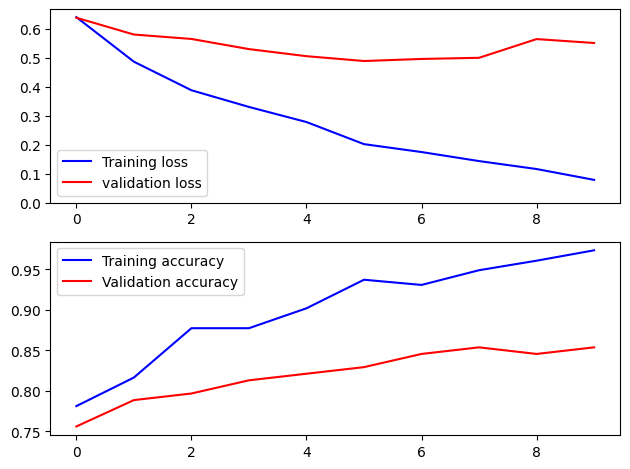

2/2 [==============================] - 79s 35s/step - loss: 0.5353 - categorical_accuracy: 0.8559
accuracy on test set =  85.59 % 


In [17]:
set_frozen_layers(fine_tune_at = 500)
results_test1 = train_and_test_model(model, learning_rate=1e-5)

Les résultats pour la dernière epoch sont (car non visible sur le pdf):  
Epoch 10/20  
15/15 [==============================] - ETA: 0s - loss: 0.0789 - categorical_accuracy: 0.9733  Restoring model weights from the end of the best epoch: 8.  
15/15 [==============================] - 1247s 83s/step - loss: 0.0789 - categorical_accuracy: 0.9733 - val_loss: 0.5505 - val_categorical_accuracy: 0.8537  
Epoch 10: early stopping  

On commence à avoir un sur-apprentissage élevé, mais on va quand même voir les résultats en entrainant encore plus de couches. ici on a un résultat de 97% sur le dataset d'entrainement et 86% sur le set de test (différence de 11%).

**Test 2** : 480 couches à ré-entrainer

nombre de couches gelées : 300 / 780
Epoch 1/20
15/15 [==============================] - 914s 59s/step - loss: 0.1190 - categorical_accuracy: 0.9562 - val_loss: 0.6088 - val_categorical_accuracy: 0.8211
Epoch 2/20
15/15 [==============================] - 906s 61s/step - loss: 0.0857 - categorical_accuracy: 0.9691 - val_loss: 0.5514 - val_categorical_accuracy: 0.8537
Epoch 3/20
15/15 [==============================] - 836s 57s/step - loss: 0.0824 - categorical_accuracy: 0.9691 - val_loss: 0.5346 - val_categorical_accuracy: 0.8618
Epoch 4/20
15/15 [==============================] - 859s 58s/step - loss: 0.0520 - categorical_accuracy: 0.9840 - val_loss: 0.5715 - val_categorical_accuracy: 0.8618
Epoch 5/20
15/15 [==============================] - 885s 59s/step - loss: 0.0293 - categorical_accuracy: 0.9936 - val_loss: 0.5779 - val_categorical_accuracy: 0.8618
Epoch 5: early stopping
End Model Fit, Time Elapsed: 73.34567931493123 minutes


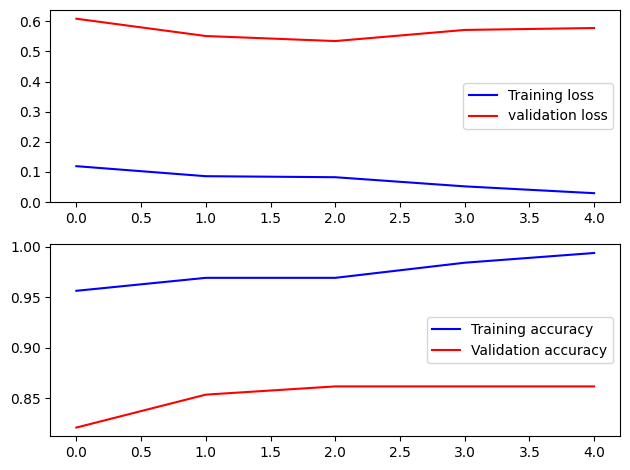

2/2 [==============================] - 39s 18s/step - loss: 0.5471 - categorical_accuracy: 0.8644
accuracy on test set =  86.44 % 


In [19]:
set_frozen_layers(fine_tune_at = 300)
results_test2 = train_and_test_model(model, learning_rate=1e-5)

Les résultats pour la dernière epoch sont (car non visible sur le pdf):  
Epoch 5/20  
15/15 [==============================] - ETA: 0s - loss: 0.0293 - categorical_accuracy: 0.9936 Restoring model weights from the end of the best epoch: 3.  
15/15 [==============================] - 885s 59s/step - loss: 0.0293 - categorical_accuracy: 0.9936 - val_loss: 0.5779 - val_categorical_accuracy: 0.8618  
Epoch 5: early stopping  

On continue à avoir un sur-apprentissage élevé. Ici on a un résultat de 99% sur le dataset d'entrainement et 86% sur le dataset de test (différence de 13%). Les résultats sur le dataset de test n'ont pas augmenté et cela a augmenté le sur-apprentissage, donc il est plus intéressant de selectionner le modèle du **Test1**.

**Test 3** : 780 couches à ré-entrainer

Ici on a testé de réentrainer toutes les couches du modèle. On remarque que le résultat n'est vraiment pas satisfaisant, on a un sur-apprentissage trés fort et des résultats sur les tests moins bon que sur l'étape précédente (environ 75%). J'ai désactivé ce calcul car trés long sans GPU.

In [20]:
# set_frozen_layers(fine_tune_at = 0)
# results_test3 = train_and_test_model(model, learning_rate=1e-5)

### Autre exploration : analyse des résultats par classe

On aimerait voir si les résultats sont homogènes par classe, ou si certaines classes font baisser les résultats.

Pour tester les résultats par classe, on relance les prédictions sur `nb_epochs` epochs, pour faire une moyenne, on stocke les bonnes prédictions dans le dictionnaire `dico_succeeded_pred`, et le total des targets par classe dans `dico_total_classes`.

In [47]:
def get_label(dataset, one_hot_vector):
        index = tf.argmax(one_hot_vector, axis=1)
        return dataset.class_names[index[0]]

def get_analyze_per_class(dataset, nb_epochs):
    dico_succeeded_pred = {class_name:0 for class_name in dataset.class_names}
    dico_total_classes = {class_name:0 for class_name in dataset.class_names}

    for nb_epoch in range(nb_epochs):
        print(f"Epoch {nb_epoch+1}/{nb_epochs}: ", end=" ")
        for img1_test, label1_test in dataset:
            prediction = model.predict(img1_test, verbose=0)
            target_label = get_label(dataset, label1_test)
            pred_label = get_label(dataset, prediction)
            dico_total_classes[target_label]+=1
            if target_label == pred_label :
                dico_succeeded_pred[target_label]+=1
        print(f"OK")
        
    return dico_succeeded_pred, dico_total_classes

In [63]:
def print_results(dico_succeeded_pred, dico_total_classes):
    print(f"Les bonnes prédictions : \n {dico_succeeded_pred}" )
    print(f"Les targets : \n {dico_total_classes}")
    moy_per_class = {k:round(v/dico_total_classes[k],2) 
                     for k,v in dico_succeeded_pred.items()}
    print(f"Moyennes par classe : \n {moy_per_class}")

Ici, on teste avec le dernier modèle compilé et entrainé, c'est à dire le modèle du **Test2**, avec 5 epochs.  
Note : on recharge le jeu de données avec un batch_size=1 pour plus de simplicité.

In [40]:
test_dataset_b1 = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           image_size=IMAGE_SIZE,
                                                           batch_size=1,
                                                           label_mode='categorical')

Found 118 files belonging to 6 classes.


In [41]:
dico_success_tl, dico_total_tl = get_analyze_per_class(test_dataset_b1, 5)

Epoch 1/5:  OK
Epoch 2/5:  OK
Epoch 3/5:  OK
Epoch 4/5:  OK
Epoch 5/5:  OK


In [64]:
print_results(dico_success_tl, dico_total_tl)

Les bonnes prédictions : 
 {'cardboard': 95, 'glass': 90, 'metal': 90, 'paper': 80, 'plastic': 90, 'trash': 65}
Les targets : 
 {'cardboard': 100, 'glass': 100, 'metal': 100, 'paper': 100, 'plastic': 100, 'trash': 90}
Moyennes par classe : 
 {'cardboard': 0.95, 'glass': 0.9, 'metal': 0.9, 'paper': 0.8, 'plastic': 0.9, 'trash': 0.72}


On remarque que pour les classes paper (0.8) et trash (0.72) on a des résultats très en dessous. Calculons les moyennes en enlevant ces classes.

In [50]:
import functools

dico_moy = {k:v/dico_total_tl[k] for k,v in dico_success_tl.items()}
moy = functools.reduce(lambda x,y: x+y, dico_moy.values())/NB_CLASSES
print(f"moyenne sur les 6 classes : {moy*100:.2f}% ")

# si on enleve trash
del dico_moy['trash']
moy = functools.reduce(lambda x,y: x+y, dico_moy.values())/(NB_CLASSES-1)
print(f"moyenne sans trash : {moy*100:.2f}% ")

# si on enleve paper en plus
del dico_moy['paper']
moy = functools.reduce(lambda x,y: x+y, dico_moy.values())/(NB_CLASSES-2)
print(f"moyenne sans trash ni paper : {moy*100:.2f}% ")

moyenne sur les 6 classes : 86.20% 
moyenne sans trash : 89.00% 
moyenne sans trash ni paper : 91.25% 


Pour comprendre pourquoi les images trash sont mal identifiées, on va afficher les `vrais positifs` (prédiction trash, target trash), les `faux négatifs` (prédiction non trash, target trash), les `faux positifs` (prédiction trash, target non trash).

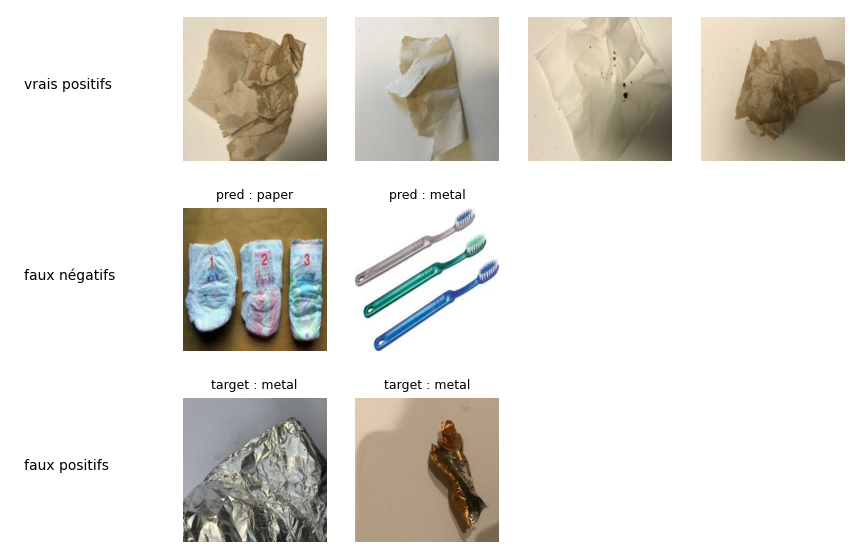

In [51]:
plt.figure(figsize=(13,7))
NB_LIGNES = 3
NB_COLONNES = 6

def affiche_image(img, title, index_subplot):
    plt.subplot(NB_LIGNES, NB_COLONNES, index_subplot)
    plt.title(title, fontdict={'fontsize':9 })
    plt.imshow(img/255.)
    plt.axis('off')

def affiche_texte(texte, index_subplot):
    plt.subplot(NB_LIGNES, NB_COLONNES, index_subplot)
    plt.text(0.1, 0.5, texte)
    plt.axis('off')
    
i = 1
affiche_texte("vrais positifs", i)
i+=1

j = 7
affiche_texte("faux négatifs", j)
j+=1

k = 13
affiche_texte("faux positifs", k)
k+=1

for img1_test, label1_test in test_dataset_b1.take(60):
    prediction = model.predict(img1_test, verbose=0)
    target_label = get_label(test_dataset_b1, label1_test)
    pred_label = get_label(test_dataset_b1, prediction)
    img_without_batch_dim = img1_test[0]
    if i<=6 and pred_label == 'trash' and target_label == pred_label :
        affiche_image(img_without_batch_dim, "", i)
        i+=1
    if j<=12 and target_label == 'trash' and target_label != pred_label :
        affiche_image(img_without_batch_dim, f"pred : {pred_label}", j)
        j+=1
    if k<=18 and pred_label == 'trash' and target_label != pred_label :
        affiche_image(img_without_batch_dim, f"target : {target_label}", k)
        k+=1
    
plt.show()

On voit que les images de la classe `trash` sont très variées, avec des formes et des couleurs trés différentes, donc compliquées à identifier par le modèle. Même nous, on pourrait s'y tromper ...

Sur un autre notebook, j'avais fait ces mêmes analyses sur le modèle en sortie du Transfer Learning avec 20 epochs, et cela était assez différent, surtout au niveau de la classe metal. Les résultats étaient :

*Les bonnes prédictions : {'cardboard': 380, 'glass': 380, 'metal': 220, 'paper': 300, 'plastic': 340, 'trash': 240}  
Les targets : {'cardboard': 400, 'glass': 400, 'metal': 400, 'paper': 400, 'plastic': 400, 'trash': 360}  
Moyennes par classe : {'cardboard': 0.95, 'glass': 0.95, 'metal': **0.55**, 'paper': 0.75, 'plastic': 0.85, 'trash': 0.67}*  
 
*moyenne sur les 6 classes : 78.61%  
moyenne sans metal : 83.33%  
moyenne sans trash ni metal : 87.50%
moyenne sans trash ni paper : 82.50%* 

La classe metal était la moins bien identifiée, puis trash, puis paper. Ici, on se rend compte que le Fine Tuning a permis d'améliorer énormement les résultats sur la classe metal en passant de 55% à 90%.

### Conclusion

Notre jeu de données est trés réduit (environ 1200 images pour 6 classes, environ 200 images par classe) mais l'on a réussit à avoir des résultats intéressant avec le Transfer Learning (presque 80%), on a essayé d'améliorer cela grâce au Fine Tuning, qui nous a permis d'atteindre les 86% sur le dataset de test, mais on est presque en situation de sur-apprentissage.

On se rend compte que ces résultats ne sont pas trés performants principalement à cause de la diversité d'images de certaines classes {trash, paper}, en enlevant ces 2 classes, on obtient sur le modèle de Transfer Learning standard déjà 82% d'accuracy sur le dataset de tests, et avec le 2eme Fine Tuning on atteint les 91%, ce qui est un résultat acceptable (car au dessus des 90%).